### This notebook contains homework for Week2. It loads stock data from yahoo finance and uses 3 algorithms to predict their future prices

In [1]:
!pip install yahoofinance

In [0]:
import yahoofinance as yf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
historical = yf.HistoricalPrices('MSFT', '2010-01-01', '2019-01-11')
dfs = historical.to_dfs()
df = dfs['Historical Prices']
df.index = pd.to_datetime(df.index)

In [4]:
print(df.tail())

                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2019-01-04   99.720001  102.510002  ...  100.786606  44060600
2019-01-07  101.639999  103.269997  ...  100.915146  35656100
2019-01-08  103.040001  103.970001  ...  101.646843  31514400
2019-01-09  103.860001  104.879997  ...  103.100357  32280800
2019-01-10  103.220001  103.750000  ...  102.437866  30067600

[5 rows x 6 columns]


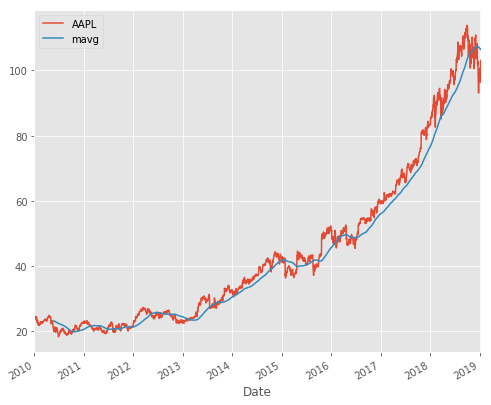

In [5]:

#Find the rolling mean of the stock
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

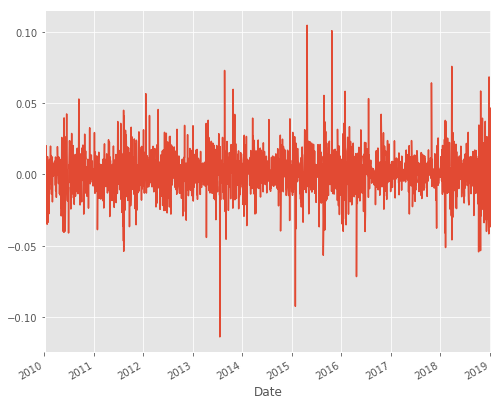

In [6]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [7]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
print(dfreg.head())
len(dfreg)

            Adj Close    Volume    HL_PCT  PCT_change
Date                                                 
2010-01-04  24.443624  38409100  1.647819    1.077727
2010-01-05  24.451517  49749600  1.485791    0.356561
2010-01-06  24.301458  58182400  1.819955   -0.356214
2010-01-07  24.048725  50559700  1.674877   -0.587653
2010-01-08  24.214581  51197400  2.087407    1.254950


2271

In [14]:
import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
print(dfreg.head())
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
print(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

            Adj Close    Volume    HL_PCT  PCT_change      label  Forecast
Date                                                                      
2010-01-04  24.443624  38409100  1.647819    1.077727  22.129574  -99999.0
2010-01-05  24.451517  49749600  1.485791    0.356561  21.892639  -99999.0
2010-01-06  24.301458  58182400  1.819955   -0.356214  22.121681  -99999.0
2010-01-07  24.048725  50559700  1.674877   -0.587653  22.105875  -99999.0
2010-01-08  24.214581  51197400  2.087407    1.254950  22.208551  -99999.0
[[-0.78940849 -0.13677484 -0.11690621  0.90797123  0.        ]
 [-0.78909361  0.34678356 -0.29190392  0.2796188   0.        ]
 [-0.79507997  0.70635777  0.06900848 -0.34142256  0.        ]
 ...
 [ 2.29048935 -0.43076453  0.47779712 -0.23399375  0.        ]
 [ 2.34847495 -0.39808527 -0.19788845  0.31290034  0.        ]
 [ 2.32204594 -0.49245602 -0.46837808  0.28971022  0.        ]]


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

#Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

#Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

#KNN regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

#DecisionTree Regression
clfdt = DecisionTreeRegressor(max_depth=5)
clfdt.fit(X_train, y_train)

#Neural Network
clfnn = MLPRegressor(hidden_layer_sizes=(20,), activation='logistic', solver='adam',
                     learning_rate='adaptive', max_iter=1000, 
                     learning_rate_init=0.01, alpha=0.01)
clfnn.fit(X_train, y_train)

#let's evaluate all of the models against eachother
confidencereg = clfreg.score(X_test,y_test)
confidencepoly2 = clfpoly2.score(X_test, y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
confidencedt = clfdt.score(X_test, y_test)
confidencenn = clfnn.score(X_test, y_test)

# results
print('The linear regression confidence is', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)
print('The DT regression confidence is ', confidencedt)
print('The Neural network confidence is ', confidencenn)

#printing some of the stocks forecasts
forecast_set_reg = clfreg.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
forecast_set_poly2 = clfpoly2.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
forecast_set_poly3 = clfpoly3.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
forecast_set_knn = clfknn.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
dfreg['Forecast'] = np.nan
results_reg = dfreg.copy()
results_poly2 = dfreg.copy()
results_poly3 = dfreg.copy()
results_knn = dfreg.copy()



The linear regression confidence is 0.9897774701056744
The quadratic regression 2 confidence is  0.9900323096752591
The quadratic regression 3 confidence is  0.9904639089490364
The knn regression confidence is  0.9722216226366532
The DT regression confidence is  0.9920821352811976
The Neural network confidence is  0.9909353961929217


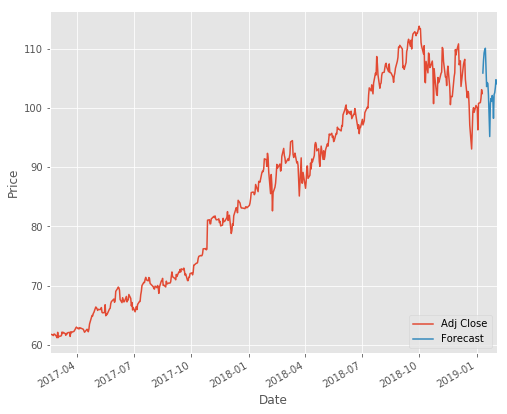

In [10]:
#results
import datetime
#Plotting the forecast with existing historical data so we can compare it to future price movements
last_date = results_reg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_reg: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    results_reg.loc[next_date] = [np.nan for _ in range(len(results_reg.columns)-1)]+[i]

results_reg['Adj Close'].tail(500).plot()
results_reg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

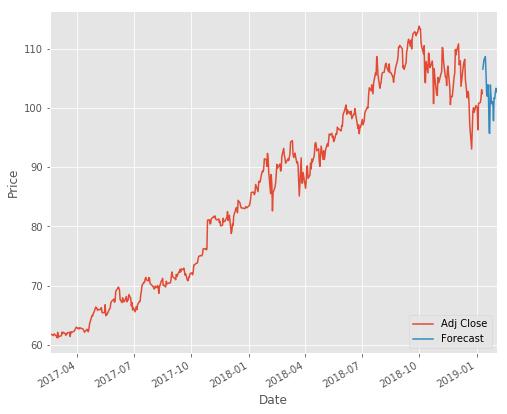

In [11]:
last_date = results_poly2.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_poly2: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    results_poly2.loc[next_date] = [np.nan for _ in range(len(results_poly2.columns)-1)]+[i]

results_poly2['Adj Close'].tail(500).plot()
results_poly2['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

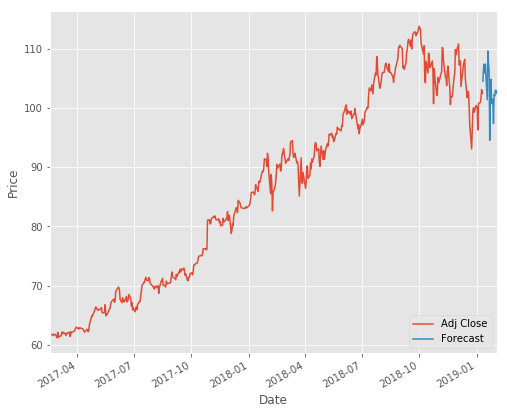

In [12]:
last_date = results_poly3.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_poly3: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    results_poly3.loc[next_date] = [np.nan for _ in range(len(results_poly3.columns)-1)]+[i]

results_poly3['Adj Close'].tail(500).plot()
results_poly3['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

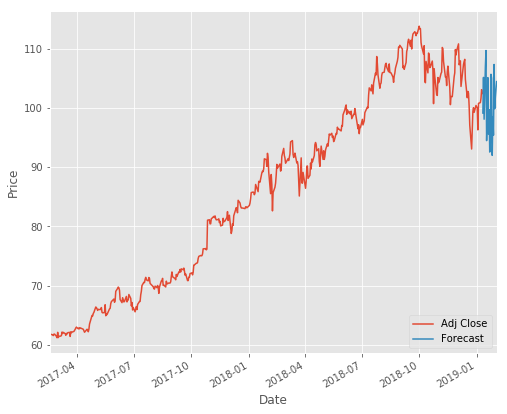

In [13]:
last_date = results_knn.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_knn: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    results_knn.loc[next_date] = [np.nan for _ in range(len(results_knn.columns)-1)]+[i]

results_knn['Adj Close'].tail(500).plot()
results_knn['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()